We first import the necessary packages.

In [1]:
import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from model import ANODE
from utils import train_reverse
from flax.training import train_state

# Enable 64 bit for more precision
jax.config.update("jax_enable_x64", True)

We now create the NODE architecture. Note that the NODE is a special case of the ANODE which has 0 augmentation dimensions.

In [2]:
rng_key = jax.random.PRNGKey(0)

model = ANODE(
    num_hidden=8,
    sample_dims=1,
    aug_dims=0,
    n_blocks=4,
)


rng_key, init_key, init_sample_key = jax.random.split(rng_key, 3)
init_samples, _ = model.get_prior_samples(init_sample_key, n_samples=1)
params = model.init(init_key, 0.0, init_samples)

We now define the unnormalized target density and log density.

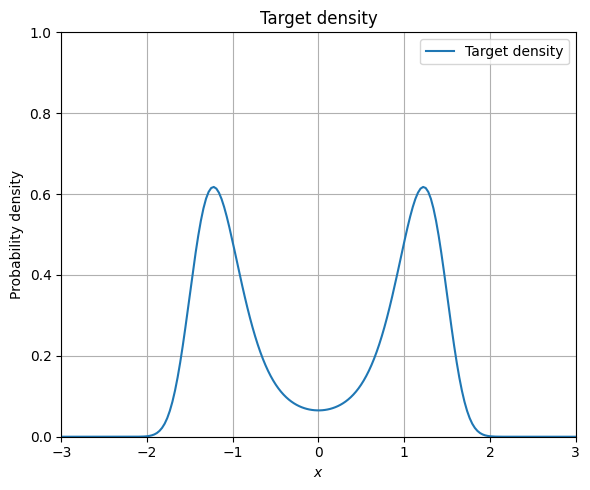

In [3]:
def p(x):
    return jnp.exp(3 * x**2 - x**4)

def log_p(x):
    return 3 * x**2 - x**4

# Visualize the target distribution (normalization constant is approxiamtely 15.36, obtained trough numerical integration)
x_linspace = jnp.linspace(-3, 3, 200)
y = p(x_linspace) / 15.36



plt.figure(figsize=(6,5))
plt.plot(x_linspace, y, label="Target density")
plt.xlabel(r"$x$")
plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.ylim(0, 1)
plt.title("Target density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


We can now train our network.

In [4]:
learning_rate = 1e-4
optimizer = optax.adam(learning_rate=learning_rate)

# Create the training state
train_state = train_state.TrainState.create(
    apply_fn=model.sample,
    params=params,
    tx=optimizer,
)

# Train the model using the reverse KL divergence for 1000 steps on a batch size of 128 samples
rng_key, train_key = jax.random.split(rng_key)
train_state, train_metrics = train_reverse(train_state, train_key, log_p, num_epochs=1_000, batch_size=128)

Epoch 0: Loss: -1.1051, ESS: 0.0308 ± 0.0270, ACCEPT_RATE: 0.4566 ± 0.0181, INTEGRATE_ERROR: 0.0557 ± 0.0870
Epoch 1: Loss: -0.8355
Epoch 2: Loss: -1.2721
Epoch 3: Loss: -1.0526
Epoch 4: Loss: -1.8824
Epoch 5: Loss: -1.5694
Epoch 6: Loss: -1.1094
Epoch 7: Loss: -0.7306
Epoch 8: Loss: -1.5517
Epoch 9: Loss: -1.1654
Epoch 10: Loss: -0.9918
Epoch 11: Loss: -1.5217
Epoch 12: Loss: -0.8779
Epoch 13: Loss: -1.2597
Epoch 14: Loss: -0.7596
Epoch 15: Loss: -1.0157
Epoch 16: Loss: -0.3074
Epoch 17: Loss: -1.7237
Epoch 18: Loss: -1.5749
Epoch 19: Loss: -1.4411
Epoch 20: Loss: -1.4472
Epoch 21: Loss: -1.1721
Epoch 22: Loss: -0.8113
Epoch 23: Loss: -0.5315
Epoch 24: Loss: -1.6257
Epoch 25: Loss: -1.6488
Epoch 26: Loss: -0.3126
Epoch 27: Loss: -1.4460
Epoch 28: Loss: -1.5962
Epoch 29: Loss: -1.5659
Epoch 30: Loss: -1.8302
Epoch 31: Loss: -1.4740
Epoch 32: Loss: -1.9371
Epoch 33: Loss: -0.9293
Epoch 34: Loss: -1.5113
Epoch 35: Loss: -1.1834
Epoch 36: Loss: -1.0748
Epoch 37: Loss: -1.5587
Epoch 38: Lo

We now visualize the learned distribution.

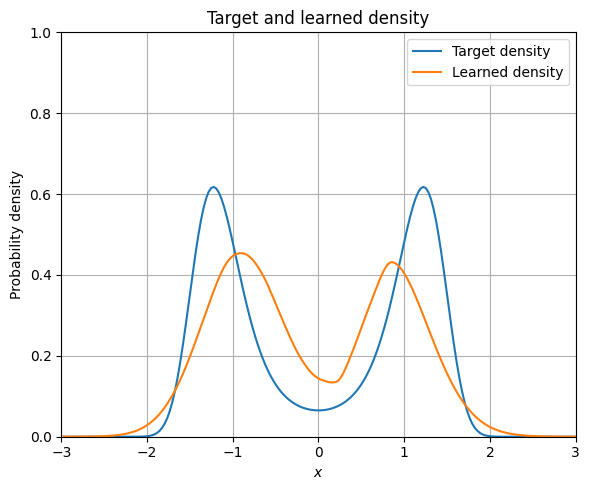

In [5]:
x_linspace = jnp.linspace(-3, 3, 200)
y = p(x_linspace) / 15.36


samples, y_learned = model.get_logp(train_state.params, x_linspace.reshape(-1, 1), rng_key)



plt.figure(figsize=(6,5))
plt.plot(x_linspace, y, label="Target density")
plt.plot(x_linspace, jnp.exp(y_learned), label="Learned density")
plt.xlabel(r"$x$")
plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.title("Target and learned density")
plt.tight_layout()
plt.show()